<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary/Outliers_Investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import MiniBatchKMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from collections import Counter

import xgboost as xgb
import lightgbm as lgb
import requests
import io

import re


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))

    # Print general dataset information
    print("\n🔹 Dataset Overview:")
    print(f"Shape: {data.shape}")  # Number of rows and columns
    print(f"Columns: {data.columns.tolist()}")  # Column names
    print("\n🔹 Data Types and Missing Values:")
    print(data.info())  # Data types and non-null counts
    print("\n🔹 Statistical Summary:")
    print(data.describe())  # Summary statistics for numerical columns

else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully. Loading into DataFrame...

🔹 Dataset Overview:
Shape: (81658, 11)
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

🔹 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81658 entries, 0 to 81657
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           81658 non-null  int64 
 1   experience_level    81658 non-null  object
 2   employment_type     81658 non-null  object
 3   job_title           81658 non-null  object
 4   salary              81658 non-null  int64 
 5   salary_currency     81658 non-null  object
 6   salary_in_usd       81658 non-null  int64 
 7   employee_residence  81658 non-null  object
 8   remote_ratio        81658 non-null  int64 
 9   company_location    81658 non-nul

In [ ]:
data = data.drop(columns=["salary", "salary_currency"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employment_type: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values


In [ ]:
# Define target variable
y = data["salary_in_usd"]

# Define feature set (keeping full dataset without simplifications)
X = data.drop(columns=["salary_in_usd"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables using One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensure train and test sets have the same columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Confirm dataset shape
print(f"✅ Train set: {X_train_encoded.shape} | Test set: {X_test_encoded.shape}")


✅ Train set: (65326, 499) | Test set: (16332, 499)


In [ ]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_true)  # Standard deviation of actual values
    rmse_sigma_ratio = rmse / std_dev  # RMSE relative to standard deviation

    print(f"📊 {model_name} Performance:")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:,.2f}")
    print(f"RMSE / σ Ratio: {rmse_sigma_ratio:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse, "RMSE / σ Ratio": rmse_sigma_ratio, "R²": r2}


In [ ]:
from matplotlib.ticker import FuncFormatter

def plot_regression_results(y_train, y_pred_train, y_test, y_pred_test, model_name="Model"):
    """
    Generates three plots:
    1. Actual vs. Predicted values for training data.
    2. Actual vs. Predicted values for test data.
    3. Distribution of residuals for both train and test sets, with statistical markers.

    Parameters:
    - y_train: True training values
    - y_pred_train: Predicted training values
    - y_test: True test values
    - y_pred_test: Predicted test values
    - model_name: String name of the model (for labeling)
    """

    # Compute residuals
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test
    residuals = np.concatenate([train_residuals, test_residuals])

    # Compute residual statistics
    mu, sigma = np.mean(residuals), np.std(residuals)
    median_residual = np.median(residuals)

    # Compute % of residuals within ±1σ
    within_1_sigma = np.mean((residuals >= mu - sigma) & (residuals <= mu + sigma)) * 100

    # Function to format tick labels in thousands (K)
    def thousands_formatter(x, pos):
        return f'${int(x/1000)}K'

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1.5]})

    y_min = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
    y_max = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

    # 1️⃣ Actual vs. Predicted (Train)
    axes[0].scatter(y_train, y_pred_train, color='blue', alpha=0.5, label="Train Data")
    axes[0].set_ylim(y_min, y_max)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k', label="Ideal Line (y = x)")
    axes[0].set_title(f"{model_name}: Train - Actual vs. Predicted Salaries")
    axes[0].set_xlabel("Actual Salary")
    axes[0].set_ylabel("Predicted Salary")
    axes[0].legend()
    axes[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 2️⃣ Actual vs. Predicted (Test)
    axes[1].scatter(y_test, y_pred_test, color='red', alpha=0.5, label="Test Data")
    axes[1].set_ylim(y_min, y_max)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label="Ideal Line (y = x)")
    axes[1].set_title(f"{model_name}: Test - Actual vs. Predicted Salaries")
    axes[1].set_xlabel("Actual Salary")
    axes[1].set_ylabel("Predicted Salary")
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 3️⃣ Residuals Distribution (Improved)
    sns.kdeplot(train_residuals, color='blue', label='Train Residuals', ax=axes[2], fill=True)
    sns.kdeplot(test_residuals, color='red', label='Test Residuals', ax=axes[2], fill=True)

    # Add statistical markers
    axes[2].axvline(mu, color='black', linestyle='solid', label=f"Mean Residual: ${mu:,.0f}")
    axes[2].axvline(median_residual, color='black', linestyle='dashed', label=f"Median Residual: ${median_residual:,.0f}")
    axes[2].axvline(mu + sigma, color='blue', linestyle='dotted')
    axes[2].axvline(mu - sigma, color='blue', linestyle='dotted', label=f"±1σ ({within_1_sigma:.1f}%, σ={sigma:,.0f})")

    # Formatting
    axes[2].axvline(0, color='black', linestyle='dashed')
    axes[2].set_title(f"{model_name}: Residuals Distribution")
    axes[2].set_xlabel("Residuals (Error)")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].xaxis.set_major_locator(plt.MaxNLocator(12))  # More X-axis ticks
    axes[2].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    plt.tight_layout()
    plt.show()


In [ ]:
# Train Linear Regression on the full dataset
print(f"🚀 Training Linear Regression on full dataset...")

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# Predict on test data
lr_y_pred_train = lr_model.predict(X_train_encoded)
lr_y_pred_test = lr_model.predict(X_test_encoded)

# Evaluate model on training data
lr_train_results = evaluate_model("Linear Regression (Train)", y_train, lr_y_pred_train)

# Evaluate model on test data
lr_test_results = evaluate_model("Linear Regression (Test)", y_test, lr_y_pred_test)


🚀 Training Linear Regression on full dataset...
📊 Linear Regression (Train) Performance:
MAE: 45,517.37
MAPE: 34.13%
RMSE: 61,146.57
RMSE / σ Ratio: 0.84
R²: 0.2947
--------------------------------------------------
📊 Linear Regression (Test) Performance:
MAE: 46,103.63
MAPE: 34.47%
RMSE: 63,672.48
RMSE / σ Ratio: 0.85
R²: 0.2749
--------------------------------------------------


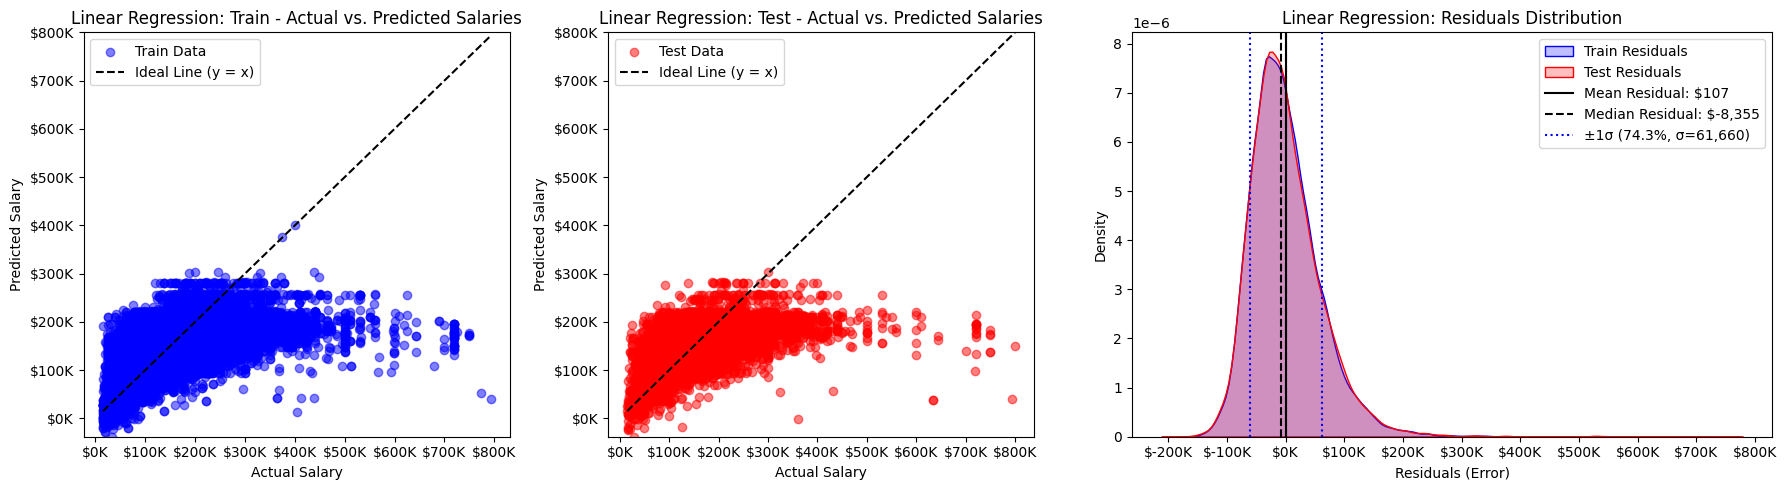

In [ ]:
plot_regression_results(y_train, lr_y_pred_train, y_test, lr_y_pred_test, model_name="Linear Regression")

In both train and test, data above 600K is getting prediction of under 200K

This is the first evaluation of the model. The results show a failure to predict extreme points (outliers) accurately, with significant errors in high-salary predictions.

The data is based on surveys, so we want to examine whether the outliers appear reliable and not a result of reporting errors or inconsistencies.

















In [ ]:
# Merge all data (Train + Test)
all_salaries = np.concatenate([y_train, y_test])

# Total number of samples
total_samples = len(all_salaries)

# Number of samples with a salary above $350K
high_salary_count = np.sum(all_salaries > 350000)

# Calculate the percentage of data
high_salary_percentage = (high_salary_count / total_samples) * 100

print(f"📊 Number of salaries above $350K: {high_salary_count}")
print(f"📊 Percentage of data above $350K: {high_salary_percentage:.2f}%")


📊 Number of salaries above $350: 1250
📊 Percentage of data above $350: 1.53%


In [ ]:
# Number of samples with a salary above $500K
high_salary_500k_count = np.sum(all_salaries > 500000)

# Calculate the percentage of data
high_salary_500k_percentage = (high_salary_500k_count / total_samples) * 100

print(f"📊 Number of salaries above $500K: {high_salary_500k_count}")
print(f"📊 Percentage of data above $500K: {high_salary_500k_percentage:.2f}%")


📊 Number of salaries above $500K: 162
📊 Percentage of data above $500K: 0.20%


In [ ]:
import pandas as pd

# Filtering for salaries above 500K
df_filtered = data[data['salary_in_usd'] >= 500000]

# Grouping by job title and counting occurrences above 500K
job_salary_stats = df_filtered.groupby('job_title').agg(
    occurrences_above_500K=('salary_in_usd', 'count')
).reset_index()

# Adding total occurrences, mean and median salary for each job title
overall_job_stats = data.groupby('job_title').agg(
    total_occurrences=('salary_in_usd', 'count'),
    mean_salary=('salary_in_usd', 'mean'),
    median_salary=('salary_in_usd', 'median')
).reset_index()

# Counting occurrences of each experience category per job title
experience_distribution = df_filtered.groupby(['job_title', 'experience_level']).size().unstack(fill_value=0)

# Counting occurrences per salary year
year_distribution = df_filtered.groupby(['job_title', 'work_year']).size().unstack(fill_value=0)

# Merging all datasets
job_salary_analysis = job_salary_stats.merge(overall_job_stats, on='job_title', how='left')
job_salary_analysis = job_salary_analysis.merge(experience_distribution, on='job_title', how='left')
job_salary_analysis = job_salary_analysis.merge(year_distribution, on='job_title', how='left')

# Sorting by occurrences above 500K
job_salary_analysis = job_salary_analysis.sort_values(by='occurrences_above_500K', ascending=False)



<ipython-input-60-32036cd4412e>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  job_salary_stats = df_filtered.groupby('job_title').agg(
<ipython-input-60-32036cd4412e>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_job_stats = data.groupby('job_title').agg(
<ipython-input-60-32036cd4412e>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  experience_distribution = df_filtered.groupby(['job_title', 'experience

In [ ]:
job_salary_analysis

,job_title,occurrences_above_500K,total_occurrences,mean_salary,median_salary,EN,EX,MI,SE,2023,2024,2025
282,Software Engineer,27,8824,189656.153218,180000.0,0,0,6,21,0,18,9
26,Analytics Engineer,19,1288,157966.682453,146050.0,1,0,7,11,2,14,3
266,Research Scientist,17,2411,196890.426379,182200.0,2,0,7,8,0,14,3
265,Research Engineer,17,1121,205393.843889,180000.0,0,0,10,7,0,15,2
145,Data Scientist,13,12461,157829.475002,151800.0,0,0,5,8,1,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...
104,Data Governance Lead,0,58,152191.724138,140000.0,0,0,0,0,0,0,0
103,Data Governance Engineer,0,14,159157.142857,144450.0,0,0,0,0,0,0,0
102,Data Governance Architect,0,2,118209.000000,118209.0,0,0,0,0,0,0,0
101,Data Governance Analyst,0,86,114248.709302,114729.5,0,0,0,0,0,0,0


In [ ]:
# 🔹 בדיקה כמה מהמרוויחים מעל 500K הם ברמת ניסיון EX (Executive)
high_salary_experience = data[data['salary_in_usd'] > 350000]['experience_level'].value_counts()

print("\n📊 Experience level distribution for salaries above $350K:")
print(high_salary_experience)



📊 Experience level distribution for salaries above $350K:
experience_level
SE    818
MI    336
EX     58
EN     38
Name: count, dtype: int64


In [ ]:
high_salary_experience = data[data['salary_in_usd'] > 500000]['experience_level'].value_counts()

print("\n📊 Experience level distribution for salaries above $500K:")
print(high_salary_experience)



📊 Experience level distribution for salaries above $500K:
experience_level
MI    81
SE    72
EN     6
EX     3
Name: count, dtype: int64


In [ ]:
filtered_data_EN = data[~((data['experience_level'] == 'EN') & (data['salary_in_usd'] > 350000))]


filtered_data_MI = filtered_data_EN[(filtered_data_EN['experience_level'] == 'MI') & (filtered_data_EN['salary_in_usd'] > 500000)]


print(f"✅ Removed {len(data) - len(filtered_data_EN)} EN entries with salaries above $350K")
print(f"📊 Identified {len(filtered_data_MI)} MI entries with salaries above $500K for review.")


✅ Removed 38 EN entries with salaries above $350K
📊 Identified 81 MI entries with salaries above $500K for review.


The dataset is based on self-reported survey data, so while it provides valuable insights, data reliability must be considered.

📌 Key Findings:

1️⃣ Few extreme outliers:

Only a small portion of salaries exceed $350K (1.5%), so most data seems reasonable.

However, a few cases were highly unrealistic, especially for Entry-Level (EN) roles.

2️⃣ Entry-Level (EN) salaries above $350K are not plausible

It is highly unlikely for an Entry-Level employee to earn $350K+, making these entries unreliable.

Decision: ❌ All EN salaries above $350K were removed.

3️⃣ Mid-Level (MI) salaries above $500K are flagged for review

While some MI employees may earn high salaries, most cases above $500K appear excessive.

Decision: 🔍 MI salaries above $500K are identified for manual review but not immediately removed.


🚀 This approach ensures that we maintain the dataset's integrity while removing the most unrealistic reports.







